# Hyperparameter Tuning and Pruning in Decision Trees - Lab

## Introduction

In this lab, you will use the titanic dataset to see the impact of tree pruning and hyperparameter tuning on the predictive performance of a decision tree classifier. Pruning reduces the size of decision trees by removing nodes of the tree that do not provide much predictive power to classify instances. Decision trees are the most susceptible out of all the machine learning algorithms to overfitting and effective pruning can reduce this likelihood. 

## Objectives

In this lab you will: 

- Determine the optimal hyperparameters for a decision tree model and evaluate the model performance

## Import necessary libraries

Let's first import the libraries you'll need for this lab. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
plt.style.use("seaborn-darkgrid")

## Import the data

The titanic dataset, available in `'titanic.csv'`, is all cleaned up and preprocessed for you so that you can focus on pruning and optimization. Import the dataset and print the first five rows of the data: 

In [2]:
# Import the data
df = pd.read_csv('titanic.csv')
df.head()

,PassengerId,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Survived
0,1,22.0,1,0,7.2500,0,0,1,0,1,0,0,1,0
1,2,38.0,1,0,71.2833,1,0,0,1,0,1,0,0,1
2,3,26.0,0,0,7.9250,0,0,1,1,0,0,0,1,1
3,4,35.0,1,0,53.1000,1,0,0,1,0,0,0,1,1
4,5,35.0,0,0,8.0500,0,0,1,0,1,0,0,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Age          891 non-null    float64
 2   SibSp        891 non-null    int64  
 3   Parch        891 non-null    int64  
 4   Fare         891 non-null    float64
 5   Pclass_1     891 non-null    int64  
 6   Pclass_2     891 non-null    int64  
 7   Pclass_3     891 non-null    int64  
 8   Sex_female   891 non-null    int64  
 9   Sex_male     891 non-null    int64  
 10  Embarked_C   891 non-null    int64  
 11  Embarked_Q   891 non-null    int64  
 12  Embarked_S   891 non-null    int64  
 13  Survived     891 non-null    int64  
dtypes: float64(2), int64(12)
memory usage: 97.6 KB


## Create training and test sets

- Assign the `'Survived'` column to `y` 
- Drop the `'Survived'` and `'PassengerId'` columns from `df`, and assign the resulting DataFrame to `X` 
- Split `X` and `y` into training and test sets. Assign 30% to the test set and set the `random_state` to `SEED` 

In [4]:
# Create X and y 
y = df['Survived']
X = df.drop(columns=['Survived','PassengerId'], axis=1)

# Split into training and test sets
SEED = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

## Train a vanilla classifier

__Note:__ The term "vanilla" is used for a machine learning algorithm with its default settings (no tweaking/tuning).

- Instantiate a decision tree 
  - Use the `'entropy'` criterion and set the `random_state` to `SEED` 
- Fit this classifier to the training data 

In [5]:
# Train the classifier using training data
dt = DecisionTreeClassifier(criterion='entropy', random_state=SEED) 
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=1)

## Make predictions 
- Create a set of predictions using the test set 
- Using `y_test` and `y_pred`, calculate the AUC (Area under the curve) to check the predictive performance

In [6]:
# Make predictions using test set 
y_pred = dt.predict(X_test)

# Check the AUC of predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7364720394736842

## Maximum Tree Depth

Let's first check for the best depth parameter for our decision tree: 

- Create an array for `max_depth` values ranging from 1 - 32  
- In a loop, train the classifier for each depth value (32 runs) 
- Calculate the training and test AUC for each run 
- Plot a graph to show under/overfitting and the optimal value 
- Interpret the results 

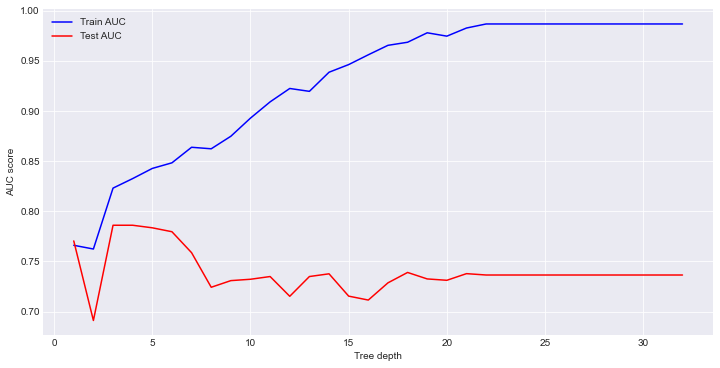

In [7]:
# Identify the optimal tree depth for given data
max_depths = list(range(1, 33))
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=SEED)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

In [8]:
# Your observations here 
# Training error decreases with increasing tree depth - clear sign of overfitting 
# Test error increases after depth=3 - nothing more to learn from deeper trees (some fluctuations, but not stable)
# Training and test errors rise rapidly between the depths of 2 and 3
# Optimal value seen here is 3

## Minimum Sample Split

Now check for the best `min_samples_splits` parameter for our decision tree 

- Create an array for `min_sample_splits` values ranging from 0.1 - 1 with an increment of 0.1 
- In a loop, train the classifier for each `min_samples_splits` value (10 runs) 
- Calculate the training and test AUC for each run 
- Plot a graph to show under/overfitting and the optimal value 
- Interpret the results

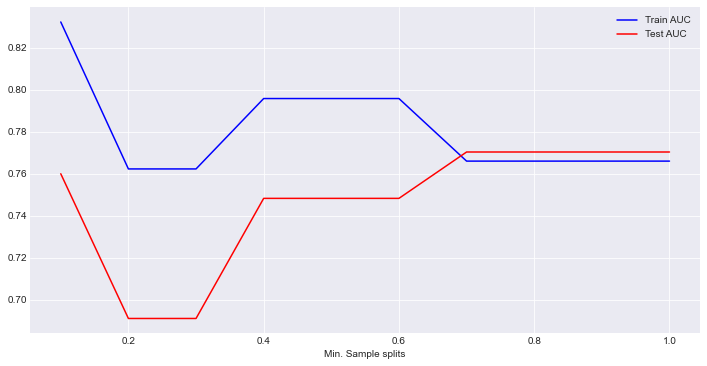

In [9]:
# Identify the optimal min-samples-split for given data
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=SEED)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.xlabel('Min. Sample splits')
plt.legend()
plt.show()

In [10]:
# Your observations here
# AUC for both test and train data stabilizes at 0.7 
# Further increase in minimum sample split does not improve learning 

## Minimum Sample Leafs

Now check for the best `min_samples_leafs` parameter value for our decision tree 

- Create an array for `min_samples_leafs` values ranging from 0.1 - 0.5 with an increment of 0.1 
- In a loop, train the classifier for each `min_samples_leafs` value (5 runs) 
- Calculate the training and test AUC for each run 
- Plot a graph to show under/overfitting and the optimal value 
- Interpret the results

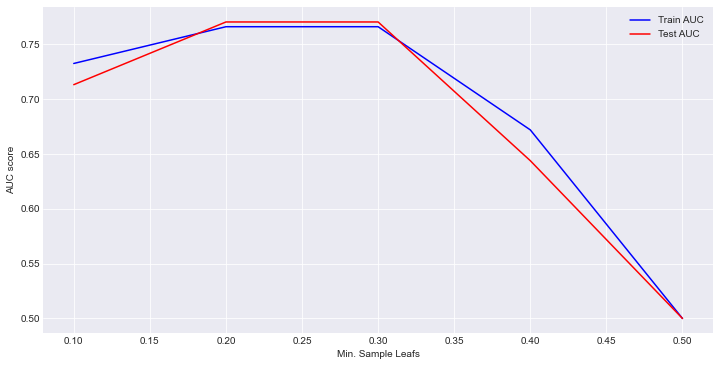

In [11]:
# Calculate the optimal value for minimum sample leafs
# Calculate the optimal value for minimum sample leafs
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf, random_state=SEED)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
plt.figure(figsize=(12,6))    
plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()

## Observations 
- AUC gives best value between 0.2 and 0.3 for both test and training sets 
- The accuracy drops down if we continue to increase the parameter value 

## Maximum Features

Now check for the best `max_features` parameter value for our decision tree 

- Create an array for `max_features` values ranging from 1 - 12 (1 feature vs all)
- In a loop, train the classifier for each `max_features` value (12 runs) 
- Calculate the training and test AUC for each run 
- Plot a graph to show under/overfitting and the optimal value 
- Interpret the results

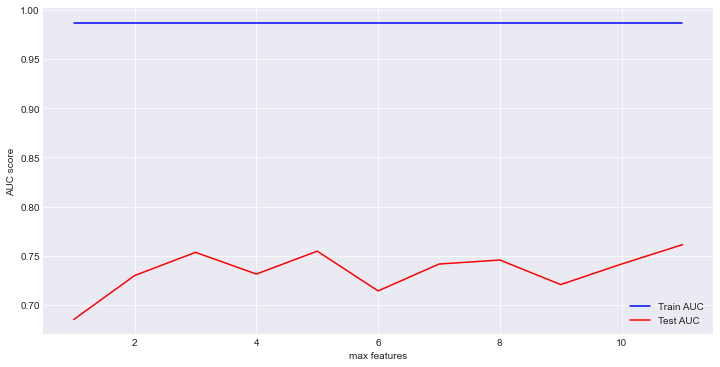

In [12]:
# Find the best value for optimal maximum feature size
# Find the best value for optimal maximum feature size
max_features = list(range(1, X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(criterion='entropy', max_features=max_feature, random_state=SEED)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_features, train_results, 'b', label='Train AUC')
plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.legend()
plt.show()

# Observations 
- No clear effect on the training dataset - flat AUC 
- Some fluctuations in test AUC but not definitive enough to make a judgement
- Highest AUC value seen at 6

## Re-train the classifier with chosen values

Now we will use the best values from each training phase above and feed it back to our classifier. Then we can see if there is any improvement in predictive performance. 

- Train the classifier with the optimal values identified 
- Compare the AUC of the new model with the earlier vanilla decision tree AUC 
- Interpret the results of the comparison

In [13]:
# Train a classifier with optimal values identified above
dt = DecisionTreeClassifier(criterion='entropy',
                           max_features=6,
                           max_depth=3,
                           min_samples_split=0.7,
                           min_samples_leaf=0.25, 
                           random_state=SEED)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6439144736842105

## Observations 
- We actually have a worse AUC than the vanilla classifier, because we tuned the hyper parameters one at a time. With more complicated (and bigger) datasets, 
- We might see an improvement in AUC/accuracy of the classifier. 

In order to address the issue of a baseline classifier performing better than a tuned one like this, a more-sophisticated technique is called a "grid search" and this will be introduced in a future lesson.

## Summary 

In this lesson, we looked at tuning a decision tree classifier in order to avoid overfitting and increasing the generalization capabilities of the classifier. For the titanic dataset, we see that identifying optimal parameter values can result in some improvements towards predictions. This idea will be exploited further in upcoming lessons and labs. 